# Benchmarks
### Run C++ benchmarks
#### store output in output.csv file for processing

In [ ]:
import pandas as pd
import subprocess
import os

def filter_lines(file_path, keywords):
    filtered_lines = []
    with open(file_path, 'r') as file:
        for line in file:
            if not any(keyword in line for keyword in keywords):
                filtered_lines.append(line)
    return filtered_lines

subprocess.run("cd cpp && make run > output.csv", shell=True)

### Process C++ benchmarks output and create tables from it

In [3]:
import pandas as pd

output_filename = 'cpp/output.csv'

# clean the csv file for processing
keywords = ['Running','csv', 'build', 'make', 'Building', 'executable', 'target', 'echo', 'Run', 'Warning', 'CPU', 'L1', 'L2', 'L3', 'Load', 'done']
filtered_lines = filter_lines(output_filename, keywords)
with open(output_filename, 'w') as file:
    for line in filtered_lines:
        file.write(line)
lines = []
with open(output_filename, 'r') as file:
    lines = file.readlines()

# Split the lines based on the empty line separator
table_lines = []
current_table = []

for line in lines:
    if line.strip():
        current_table.append(line)
    elif current_table:
        table_lines.append(current_table)
        current_table = []
if(current_table is not []):
    table_lines.append(current_table)
c_tables = []

for lines in table_lines:
    table = [line.strip().split(',') for line in lines]
    df = pd.DataFrame(table[1:], columns=table[0])
    columns_to_drop = ['bytes_per_second', 'items_per_second', 'label', 'error_occurred', 'error_message']
    df = df.drop(columns=columns_to_drop)
    c_tables.append(df)


### Run the following cell to display C++ tables

In [ ]:
print('C++ Benchmarks')
table_names = ["Simple eertree construction - Classic tree", "Simple eertree construction - Direct links tree", "Simple eertree consutrction - semi persistent tree",
                "Msubstr - Classic tree", "Msubstr - Direct links tree", "Msubstr - Semi persistent tree", 
                "Queries - Direct links tree", "Queries - Semi persistent tree",
                "Rich - Direct links tree", "Rich - Semi persistent tree"]
for idx, df in enumerate(c_tables):
    print(f"--- C++ Benchmarks ---")
    print(table_names[idx])

    table_style = df.style.set_properties(**{'text-align': 'center'})

# Define a color function to apply to the cells
    def color_cell(value):
        if value is not None and (value == "s" or "bench" in value):
            return 'color: green'
        if value is not None and value.isdigit():
            return 'color: yellow'
        return 'color: white'

    table_style = table_style.applymap(color_cell)
    display(table_style)
    print()

### Run Haskell benchmarks
#### store output in output.txt file for processing
PS: you may need to run this command manually

In [ ]:
output_filename = 'hs/output.txt'  

subprocess.run('stack bench 2> hs/output.txt', shell=True, check=True)

### Process haskell benchmarks and create tables for it

In [5]:
import pandas as pd

# Clean the ouput:
output_filename = 'hs/output.txt'  
keywords = ['Completed', 'Running']
filtered_lines = filter_lines(output_filename, keywords)
with open(output_filename, 'w') as file:
    for line in filtered_lines:
        file.write(line)
lines = []
with open('hs/output.txt', 'r') as file:
    lines = file.readlines()

haskell_dfs = []
current_benchmark = None
current_data = []
haskell_table_names = []
for line in lines:
    line = line.strip()
    
    # Check if it is a new benchmark
    if 'RUNNING...' in line:
        haskell_table_names.append((line.split(' '))[1])
        current_benchmark = line.split(' ')[-1]
    elif 'FINISH' in line :
        df = pd.DataFrame(current_data, columns=['Metric', current_benchmark])
        haskell_dfs.append(df)
        
        current_benchmark = None
        current_data = []
    elif line:
        metric, value = line.split(" ", 1)
        metric = metric.strip()
        value = value.strip()
        
        current_data.append([metric, value])

### Run the following cell to display haskell tables

In [ ]:
# Print the created dataframes
for idx, df in enumerate(haskell_dfs):
    print(f"--- haskell ---")
    print(haskell_table_names[idx])

    table_style = df.style.set_properties(**{'text-align': 'center'})
    display(table_style)
    print()

### Generate graphs for Simple tree construction

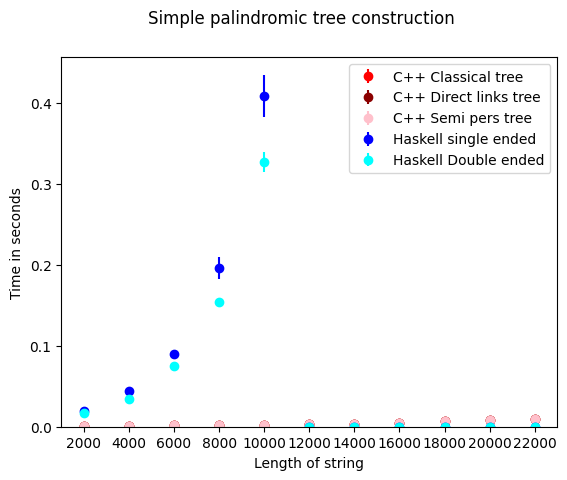

In [8]:
# Manual extraction of desired values
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

def convert_to_second(str):
    if(str == "ns"):
        return 0.000000001
    if(str == "μs"):
        return 0.000001
    if(str == "ms"):
        return 0.001
    if(str == "cs"):
        return 0.01
    if(str == "s"):
        return 1.0
    print(f"UNKNOWN {str}")
    return 1.0
# Haskell indices
list_ind, simple_ind, msubstr_ind, rich_ind, queries_ind = 0, 0, 0, 0, 0
for i in range(0, len(haskell_table_names)):
    if(haskell_table_names[i] == "list:"):
        list_ind = i
    elif(haskell_table_names[i] == "simple:"):
        simple_ind = i
    elif(haskell_table_names[i] == "msubstr-bench:"):
        msubstr_ind = i
    elif(haskell_table_names[i] == "rich-bench:"):
        rich_ind = i
    elif(haskell_table_names[i] == "queries-bench:"):
        queries_ind = i

# create data
x = []
for i in range (1, 12):
    x.append(i * 2000)
# C++ data for simple construction
c_mean, c_stddev = [], []
for j in range(3):
    c_mean.append([])
    c_stddev.append([])
    for index, row in c_tables[j].iterrows():
        if "mean" in row[0]:
            c_mean[j].append(float(row[2]))
        if "stddev" in row[0]:
            c_stddev[j].append(float(row[2]))

# Haskell data for simple construction
hs_mean, hs_stddev = [[], []], [[], []]
desired = False
for index, row in haskell_dfs[simple_ind].iterrows():
    if "@26/len" in row[1]:
        desired = True
    if desired and "mean" in row[0]:
        hs_mean[0].append(float(row[1].split(' ')[0]) * convert_to_second(row[1].split(' ')[1]) )
    if desired and "std" in row[0]:
        row[1] = " ".join(row[1].split())
        hs_stddev[0].append(float(row[1].split(' ')[1]) * convert_to_second(row[1].split(' ')[2]) )
    if(len(hs_stddev[0]) == 11):
        break
desired = False
for index, row in haskell_dfs[list_ind].iterrows():
    if "@26/len" in row[1]:
        desired = True
    if desired and "mean" in row[0]:
        hs_mean[1].append(float(row[1].split(' ')[0]) * convert_to_second(row[1].split(' ')[1]) )
    row[1] = " ".join(row[1].split())
    if desired and "std" in row[0]:
        hs_stddev[1].append(float(row[1].split(' ')[1]) * convert_to_second(row[1].split(' ')[2]) )
    if(len(hs_stddev[1]) == 11):
        break

plt.xticks(x)
plt.errorbar(x, c_mean[0], yerr=c_stddev[0], fmt="o", color="r", label="C++ Classical tree")
plt.errorbar(x, c_mean[1], yerr=c_stddev[1], fmt="o", color="darkred", label="C++ Direct links tree")
plt.errorbar(x, c_mean[2], yerr=c_stddev[2], fmt="o", color="pink", label="C++ Semi pers tree")
plt.errorbar(x, hs_mean[0], yerr=hs_stddev[0], fmt="o", color="b", label="Haskell single ended")
plt.errorbar(x,hs_mean[1], yerr=hs_stddev[1], fmt="o", color="cyan", label="Haskell Double ended")
plt.ylabel("Time in seconds")
plt.xlabel(f"Length of string")
plt.ylim(0)
plt.suptitle("Simple palindromic tree construction")
plt.legend()
plt.show()

### Generate graphs for Msubstr

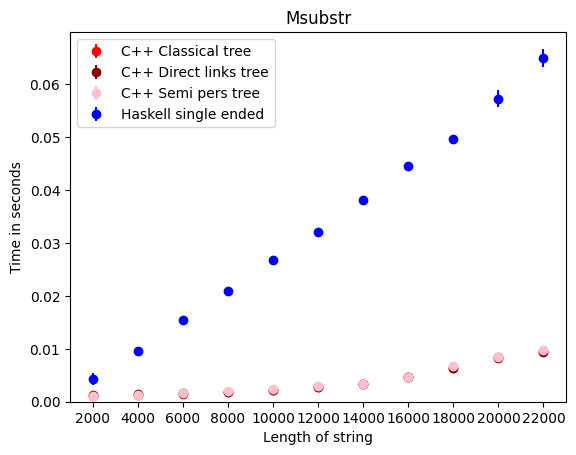

In [9]:
c_mean , c_stddev = [], []
hs_mean, hs_stddev = [[]], [[]]
for j in range (3, 6):
    c_mean.append([])
    c_stddev.append([])
    for index, row in c_tables[j].iterrows():
        if "mean" in row[0]:
            c_mean[j-3].append(float(row[2]))
        if "stddev" in row[0]:
            c_stddev[j-3].append(float(row[2]))

# plot lines
plt.xticks(x)
plt.errorbar(x, c_mean[0], yerr=c_stddev[0], fmt="o", color="r", label="C++ Classical tree")
plt.errorbar(x, c_mean[1], yerr=c_stddev[1], fmt="o", color="darkred", label="C++ Direct links tree")
plt.errorbar(x, c_mean[2], yerr=c_stddev[2], fmt="o", color="pink", label="C++ Semi pers tree")


for index, row in haskell_dfs[msubstr_ind].iterrows():
    if "mean" in row[0]:
        hs_mean[0].append(float(row[1].split(' ')[0]) * convert_to_second(row[1].split(' ')[1]) )
    row[1] = " ".join(row[1].split())
    if "std" in row[0]:
        hs_stddev[0].append(float(row[1].split(' ')[1]) * convert_to_second(row[1].split(' ')[2]) )
    if(len(hs_stddev[0]) == 11):
        break
plt.errorbar(x, hs_mean[0], yerr=hs_stddev[0], fmt="o", color="b", label="Haskell single ended")
plt.ylabel("Time in seconds")
plt.xlabel(f"Length of string")
plt.ylim(0)
plt.legend()
plt.title('Msubstr')
plt.show()

### Generate graphs for Queries

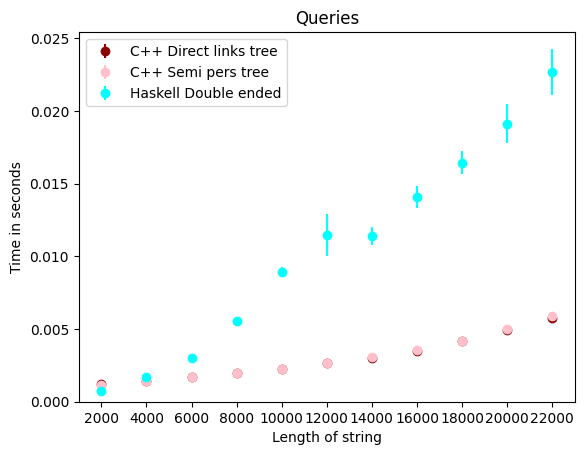

In [10]:

c_mean , c_stddev = [], []
hs_mean, hs_stddev = [[]], [[]]
for j in range (6, 8):
    c_mean.append([])
    c_stddev.append([])
    for index, row in c_tables[j].iterrows():
        if "mean" in row[0]:
            c_mean[j-6].append(float(row[2]))
        if "stddev" in row[0]:
            c_stddev[j-6].append(float(row[2]))

# plot lines
plt.xticks(x)
plt.errorbar(x, c_mean[0], yerr=c_stddev[0], fmt="o", color="darkred", label="C++ Direct links tree")
plt.errorbar(x, c_mean[1], yerr=c_stddev[1], fmt="o", color="pink", label="C++ Semi pers tree")

for index, row in haskell_dfs[queries_ind].iterrows():
    if "mean" in row[0]:
        hs_mean[0].append(float(row[1].split(' ')[0]) * convert_to_second(row[1].split(' ')[1]) )
    row[1] = " ".join(row[1].split())
    if "std" in row[0]:
        hs_stddev[0].append(float(row[1].split(' ')[1]) * convert_to_second(row[1].split(' ')[2]) )
    if(len(hs_stddev[0]) == 11):
        break
plt.errorbar(x, hs_mean[0], yerr=hs_stddev[0], fmt="o", color="cyan", label="Haskell Double ended")
plt.ylabel("Time in seconds")
plt.xlabel(f"Length of string")
plt.ylim(0)
plt.legend()
plt.title('Queries')
plt.show()

### Generate graphs for rich

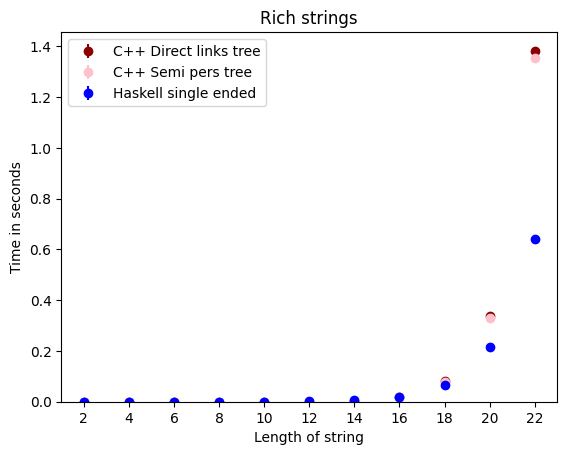

In [11]:

x = []
for i in range (1, 12):
    x.append(2*i)
c_mean , c_stddev = [], []
hs_mean, hs_stddev = [[]], [[]]
for j in range (8, 10):
    c_mean.append([])
    c_stddev.append([])
    for index, row in c_tables[j].iterrows():
        if "mean" in row[0]:
            c_mean[j-8].append(float(row[2]))
        if "stddev" in row[0]:
            c_stddev[j-8].append(float(row[2]))

# plot lines
plt.xticks(x)
plt.errorbar(x, c_mean[0], yerr=c_stddev[0], fmt="o", color="darkred", label="C++ Direct links tree")
plt.errorbar(x, c_mean[1], yerr=c_stddev[1], fmt="o", color="pink", label="C++ Semi pers tree")

for index, row in haskell_dfs[rich_ind].iterrows():
    if "mean" in row[0]:
        hs_mean[0].append(float(row[1].split(' ')[0]) * convert_to_second(row[1].split(' ')[1]) )
    row[1] = " ".join(row[1].split())
    if "std" in row[0]:
        hs_stddev[0].append(float(row[1].split(' ')[1]) * convert_to_second(row[1].split(' ')[2]) )
    if(len(hs_stddev[0]) == 11):
        break
plt.errorbar(x, hs_mean[0], yerr=hs_stddev[0], fmt="o", color="b", label="Haskell single ended")
plt.ylabel("Time in seconds")
plt.xlabel(f"Length of string")
plt.ylim(0)
plt.legend()
plt.title('Rich strings')
plt.show()